In [ ]:
# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

# Importing and Creating Training & Testing Sets


In [3]:
original_train = pd.read_csv('../train.csv',header = 0)
original_train['dataset'] = 'train'
print original_train.shape

(10886, 13)


In [4]:
original_test = pd.read_csv('../test.csv',header = 0)
original_test['dataset'] = 'test'
print original_test.shape

(6493, 10)


In [5]:
df_complete =  original_train.copy().append(original_test.copy())
#df_complete = df_complete.drop(['casual','registered'], axis = 1)
df_complete = df_complete.drop(['count'], axis = 1)

In [6]:
#add the natural dissater feature
#df_complete['nat_dis'] = 0


In [7]:
# Make the datetime the index
df_complete['datetime'] = pd.to_datetime(df_complete['datetime'])

df_complete.index = df_complete['datetime']
del df_complete['datetime']


In [8]:
# Make sure we have all the complete values of the series
idx = pd.date_range('2011-01-01 00:00:00', '2012-12-31 23:00:00', freq='H')
df_complete = df_complete.reindex(idx)

In [9]:
# Missing entries? let's try to interpolate to get that info
missing = df_complete[pd.isnull(df_complete['atemp'])]
missing.shape

(165, 11)

In [10]:
df_complete["weather"] = df_complete["weather"].interpolate(method='time').apply(np.round)
df_complete["temp"] = df_complete["temp"].interpolate(method='time')
df_complete["atemp"] = df_complete["atemp"].interpolate(method='time')
df_complete["humidity"] = df_complete["humidity"].interpolate(method='time').apply(np.round)
df_complete["windspeed"] = df_complete["windspeed"].interpolate(method='time')
df_complete["season"] = df_complete["season"].interpolate(method='time').apply(np.round)
df_complete["workingday"] = df_complete["workingday"].interpolate(method='time').apply(np.round)
df_complete["holiday"] = df_complete["holiday"].interpolate(method='time').apply(np.round)
#df_complete["nat_dis"] = df_complete["season"].interpolate(method='time').apply(np.round)
#df_complete["count"] = df_complete["count"].interpolate(method='time').apply(np.round)

#df_complete.loc[missing.index, "dataset"] = 'train'
#df_complete.loc[df_complete['dataset']=='test', 'count'] = float('NaN')

In [11]:
missing2 = df_complete[pd.isnull(df_complete['atemp'])]
missing2.shape

(0, 11)

In [12]:
df_complete.loc[missing.index].head()

,atemp,casual,dataset,holiday,humidity,registered,season,temp,weather,windspeed,workingday
2011-01-02 05:00:00,21.9675,NaN,NaN,0.0,86.0,NaN,1.0,18.040000,2.0,16.498750,0.0
2011-01-03 02:00:00,7.8300,NaN,NaN,0.0,45.0,NaN,1.0,7.653333,1.0,27.333767,1.0
2011-01-03 03:00:00,7.3250,NaN,NaN,0.0,46.0,NaN,1.0,7.106667,1.0,26.668233,1.0
2011-01-04 03:00:00,8.3325,NaN,NaN,0.0,63.0,NaN,1.0,5.740000,1.0,7.500650,1.0
2011-01-05 03:00:00,10.6075,NaN,NaN,0.0,61.0,NaN,1.0,8.200000,1.0,10.502250,1.0


In [13]:
#df_complete['month'] = df_complete.index.month
#df_complete['dayOfMonth'] = df_complete.index.day
df_complete['day'] = df_complete.index.dayofweek
df_complete['week'] = df_complete.index.week
df_complete['hour'] = df_complete.index.hour

# Initial Data View

In [14]:
df_complete[df_complete['dataset']=='test'].head(2)

,atemp,casual,dataset,holiday,humidity,registered,season,temp,weather,windspeed,workingday,day,week,hour
2011-01-20 00:00:00,11.365,NaN,test,0.0,56.0,NaN,1.0,10.66,1.0,26.0027,1.0,3,3,0
2011-01-20 01:00:00,13.635,NaN,test,0.0,56.0,NaN,1.0,10.66,1.0,0.0000,1.0,3,3,1


In [15]:
df_complete.describe()

D:\Software\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,atemp,casual,holiday,humidity,registered,season,temp,weather,windspeed,workingday,day,week,hour
count,17544.000000,10886.000000,17544.000000,17544.000000,10886.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,23.697851,36.021955,0.029241,62.842909,155.552177,2.496580,20.296823,1.432342,12.794676,0.683482,3.002736,26.534884,11.500000
std,8.625972,49.960477,0.168485,19.304095,151.039033,1.110079,7.920885,0.645414,8.234295,0.465131,2.003470,15.066700,6.922384
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.820000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,16.665000,NaN,0.000000,48.000000,NaN,2.000000,13.940000,1.000000,7.001500,0.000000,1.000000,13.000000,5.750000
50%,24.240000,NaN,0.000000,63.000000,NaN,3.000000,20.500000,1.000000,12.998000,1.000000,3.000000,27.000000,11.500000
75%,31.060000,NaN,0.000000,79.000000,NaN,3.000000,27.060000,2.000000,16.997900,1.000000,5.000000,40.000000,17.250000
max,50.000000,367.000000,1.000000,100.000000,886.000000,4.000000,41.000000,4.000000,56.996900,1.000000,6.000000,52.000000,23.000000


In [ ]:
df_complete.dtypes

In [ ]:
df_complete.shape

# Utils

In [16]:
# Function that prints the prediction according the submission format
def printPrediction(pred, fileName='pred.csv'):
    str_prediction = "datetime,count\n"
    for i in range(0, len(pred)):
        datetime = original_test['datetime'][i]
        currentPred = int(round(pred[i]))
        str_prediction += "{},{}\n".format(datetime, currentPred)

    #print str_prediction
    f = open(fileName,'w')
    f.write(str_prediction)
    f.close()

In [17]:
# Function that gets the range of an specific day
def get_day_range(day):
    day_end = day + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day, day_end, freq="H")

# Adding new Features

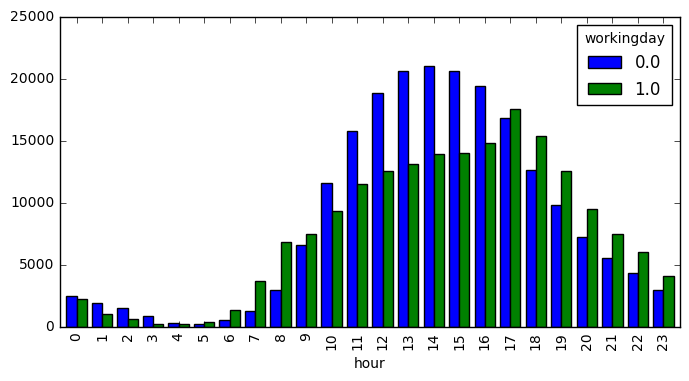

In [18]:
# rentals by hour, split by working day (or not)
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['hour', 'workingday'])['casual'].agg('sum').unstack()

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);

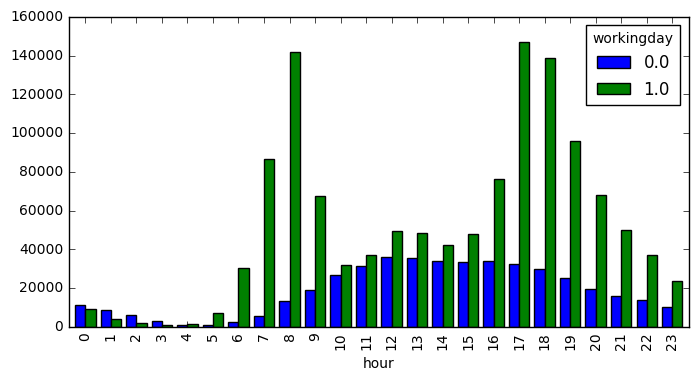

In [19]:
# rentals by hour, split by working day (or not)
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['hour', 'workingday'])['registered'].agg('sum').unstack()

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);

In [20]:
## Add Rush Hours according to histograms
df_complete['casual_rush'] = df_complete[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  11 <= x['hour'] <= 19)
        or (x['workingday'] == 0 and  10 <= x['hour'] <= 18)], axis = 1)

df_complete['registered_rush'] = df_complete[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  (6 <= x['hour'] <= 9 or 16 <= x['hour'] <= 21))
        or (x['workingday'] == 0 and  9 <= x['hour'] <= 22)], axis = 1)

In [ ]:
#df_complete['ideal'] = df_complete[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
#df_complete['sticky'] = df_complete[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)

In [21]:
## Adding some missed "holydays"

# tax day
df_complete.loc[get_day_range(pd.datetime(2011, 4, 15)), "workingday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 4, 16)), "workingday"] = 1

# thanksgiving friday
df_complete.loc[get_day_range(pd.datetime(2011, 11, 25)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 11, 23)), "workingday"] = 0

# tax day
df_complete.loc[get_day_range(pd.datetime(2011, 4, 15)), "holiday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
df_complete.loc[get_day_range(pd.datetime(2011, 11, 25)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 11, 23)), "holiday"] = 1

#pre christmas / new year
df_complete.loc[get_day_range(pd.datetime(2011, 12, 24)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 12, 24)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 12, 24)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 12, 24)), "workingday"] = 0

df_complete.loc[get_day_range(pd.datetime(2011, 12, 31)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 12, 31)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 12, 31)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 12, 31)), "workingday"] = 0




#storms
df_complete.loc[get_day_range(pd.datetime(2012, 5, 21)), "nat_dis"] = 1
#tornado
df_complete.loc[get_day_range(pd.datetime(2012, 6, 1)), "nat_dis"] = 1

#January 8–13, 2011 North American blizzard
df_complete.loc[get_day_range(pd.datetime(2011, 1, 9)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 1, 10)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 1, 11)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 1, 12)), "nat_dis"] = 1

#Earthquake Aug. 23, 2011
df_complete.loc[get_day_range(pd.datetime(2011, 8, 23)), "nat_dis"] = 1

#Hurricane Irene 21 - 30  Aug-11
df_complete.loc[get_day_range(pd.datetime(2011, 8, 22)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 23)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 24)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 25)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 26)), "nat_dis"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 8, 27)), "nat_dis"] = 1


In [22]:
df_train = df_complete[df_complete['dataset'] == 'train']
del df_train['dataset']


df_train_y_c = df_train['casual'].values
df_train_y_r = df_train['registered'].values
df_train_y = df_train_y_c + df_train_y_r

df_train_x = df_train.drop(['casual', 'registered'],axis = 1)#.values

In [23]:
df_test = df_complete[df_complete['dataset'] == 'test']
del df_test['dataset']
#del df_test['count']
del df_test['casual']
del df_test['registered']

# Models

In [24]:
# Cross Validation Generator
cv = cross_validation.ShuffleSplit(len(df_train_x), n_iter=3, test_size=0.2,
    random_state=0)

 ## Time Series

In [ ]:
type(df_train)

In [ ]:
dates = pd.date_range('2011-01-01 00:00:00', '2012-12-19 23:00:00', freq='H')
#original_train.sort_values('datetime', ascending = True).head()
dates

In [ ]:
AO = pd.Series(df_train['count'], index=dates)
AO

In [ ]:
#df_train[['datetime', 'temp']]

## Decision Tree

In [ ]:
#Finding best parameters
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_train_x, df_train_y, test_size=0.3, random_state=0)

tuned_parameters = [
    {'max_depth':[9,10,11,20,25,50]},
    {'min_samples_leaf':[1,2,5,10,50,100]},
    {'min_samples_split':[1,2,5,10,50,100]},
    {'presort':[True, False]},
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}]   
    
scores = ['r2']

for score in scores:
    
    print score
    
    clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    
    #best_estimator_ returns the best estimator chosen by the search
    print(clf.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""

In [ ]:
# Cross Validation
dtr = tree.DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
for train, test in cv:
    clf = dtr.fit(df_train_x[train], df_train_y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        clf.score(df_train_x[train], df_train_y[train]), clf.score(df_train_x[test], df_train_y[test])))

In [ ]:
# Predicting & Exporting File
dtr_pred = dtr.predict(df_test)
printPrediction(dtr_pred)


## Random Forest

In [ ]:
#Finding best parameters
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_train_x, df_train_y, test_size=0.3, random_state=0)

tuned_parameters = [
    {'max_depth':[50,100, 500, 1000]}, #Best: 1000
    #{'n_estimators':[1000, 10000]}, #We assume is 1000
    {'min_samples_leaf':[1,2,5,10,50,100]}, #2
    {'min_samples_split':[1,2,5,10,50,100]}, #10
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}] #0.0    
    
scores = ['r2']

for score in scores:
    
    print score
    
    clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    
    #best_estimator_ returns the best estimator chosen by the search
    print(clf.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""





In [ ]:
# Cross Validation
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
#rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
#           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
#           min_samples_split=1, min_weight_fraction_leaf=0.0,
#           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
#           verbose=0, warm_start=False)

    
for train, test in cv:
    clf = rfr.fit(df_train_x[train], df_train_y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        clf.score(df_train_x[train], df_train_y[train]), clf.score(df_train_x[test], df_train_y[test])))

In [25]:
# Predicting & Exporting File
#rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
#           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
#           min_samples_split=10, min_weight_fraction_leaf=0.0,
#           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
#           verbose=0, warm_start=False)
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

rfr.fit(df_train_x, df_train_y_c)
rfr_pred_c = np.array(rfr.predict(df_test))

rfr.fit(df_train_x, df_train_y_r)
rfr_pred_r = np.array(rfr.predict(df_test))

rfr_pred = rfr_pred_c + rfr_pred_r
printPrediction(rfr_pred)


In [ ]:
# Predicting & Exporting File
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

rfr.fit(df_train_x, df_train_y)
rfr_pred = np.array(rfr.predict(df_test))

printPrediction(rfr_pred)

In [ ]:
df_train_x